## Part I: Read Data and Pre-Process

Import phcovid package

In [15]:
import numpy as np
import pandas as pd
import os, sys
package_dir = os.path.normpath(os.getcwd() + os.sep + os.pardir) + os.sep +'phcovid'
sys.path.append(package_dir)

In [17]:
from phcovid import get_cases

Use get_cases module to extract latest data regarding PH Covid-19 cases in an analysis friendly format

In [18]:
df = get_cases()

In [27]:
df.head()

,case_no,age,sex,nationality,residence,travel_history,symptoms,confirmation_date,facility,latitude,longitude,status,epi_link,date,contacts,num_contacts
0,PH1,38.0,Female,Chinese,None,Yes (China); Wife of PH2,,1/30/2020,San Lazaro Hospital,14.613754,120.980815,,,1/29/2020 16:00,[PH2],1
1,PH2,44.0,Male,Chinese,None,Yes (China); Husband of PH1,,1/30/2020,San Lazaro Hospital,14.613754,120.980815,,,1/29/2020 16:00,[PH1],1
2,PH3,60.0,Female,Chinese,None,Yes (China),,1/30/2020,ACE Medical Center,9.634451,123.869198,,,1/29/2020 16:00,[],0
3,PH4,48.0,Male,Filipino,Taguig City,Yes (Japan),,3/5/2020,University of the East Ramon Magsaysay Memoria...,14.607030,121.020581,,,3/4/2020 16:00,[],0
4,PH5,62.0,Male,Filipino,Rizal,Husband of PH6,,3/5/2020,Research Institute for Tropical Medicine,14.409523,121.037122,,,3/4/2020 16:00,[PH6],1


In [58]:
#For use in graph analysis, we will create a column with case code [PHX] converted to numeric [X]
def parse_ints(s):
    num_list = []
    for i in s:
        num_list = num_list + [i.split('H')[-1]]
    return num_list
        

df['case_no_int'] = df['case_no'].apply(lambda x: x.split('H')[-1]).astype(int)
df['contacts_int'] = df['contacts'].apply(lambda x: parse_ints(x))

## Part II: Connected Components Analysis

<b>Step 1:</b> Create a graph to map all <u>direct connections</u> of each case.

In [59]:
#Create an undirected graph of all connections
contact_map = {}
def add_edge(s, d, curr_dict):
    try:
        curr_dict[s].append(d)
    except KeyError:
        curr_dict[s] = []
        curr_dict[s].append(d)

for row in df.itertuples():
    current = getattr(row, 'case_no_int')
    contact_list = getattr(row, 'contacts_int')
    for c in pd.Series(contact_list).unique():
        add_edge(int(current), int(c), contact_map)
        add_edge(int(c), int(current), contact_map)
    
    if(len(contact_list)==0):
        contact_map[int(current)] = []

for key in contact_map.keys():
    contact_map[key] = list(set(contact_map[key]))

<b>Step 2:</b> Use Depth First Search on the graph built in Step 1 to a.) identify <i>networks</i> of inter-connected cases and b.) count the number of networks and the number of cases in each network.

In [60]:
cnt = len(df)
visited = [False for i in range(1,cnt+2)]
visited_pre = [False for i in range(1,cnt+2)]
parent = [-1 for i in range(1,cnt+2)]
def dfs (v, g):
    #dfs from node v in graph (dict) g
    visited[v] = True
    for node in g[v]:
        if(not visited[node]):
            parent[node] = v
            dfs(node, g)
            
cnt_cc = 0
comp_list = {}
for i in range(1, cnt+1):
    if(not visited[i]):
        cnt_cc+=1
        dfs(i, contact_map)
        comp_list[cnt_cc-1] = []
        
        for j in range(1, cnt+1):
            if(not visited_pre[j] and visited[j]):
                visited_pre[j] = visited[j]
                comp_list[cnt_cc-1].append(j)

<b>a. Multiple cases, especially the initial ones can be traced to networks of 3+ people where transmission occured.</b> The largest network is comprised of 8 people: [12, 34, 35, 42, 43, 84, 86, 204].
<br>
<br>
<i>List of all networks with 3+ Cases shown below:</i>

In [61]:
print("List of all Networks with 3+ cases:")
for key in comp_list.keys():
    current_list = []
    if(len(comp_list[key])>=3):
        for i in comp_list[key]:
            current_list = current_list + ['PH' + str(i)]
        print(f'Network {key}: {current_list}')

List of all Networks with 3+ cases:
Network 3: ['PH5', 'PH6', 'PH38']
Network 6: ['PH9', 'PH27', 'PH28', 'PH29', 'PH30', 'PH31']
Network 9: ['PH12', 'PH34', 'PH35', 'PH42', 'PH43', 'PH84', 'PH86', 'PH204']
Network 16: ['PH21', 'PH65', 'PH66', 'PH67']
Network 28: ['PH41', 'PH44', 'PH87', 'PH112']
Network 33: ['PH49', 'PH52', 'PH183']
Network 35: ['PH51', 'PH134', 'PH135']
Network 140: ['PH169', 'PH170', 'PH176']


<b>b. Largest Network (Network 9) has loose connections and is split among multiple hospitals in NCR across 10 days. </b> <br>
<i>Network details are shown below:</i>

In [62]:
df[df['case_no_int'].isin(comp_list[9])]

,case_no,age,sex,nationality,residence,travel_history,symptoms,confirmation_date,facility,latitude,longitude,status,epi_link,date,contacts,num_contacts,case_no_int,contacts_int
11,PH12,56.0,Male,Filipino,Manila,"Contact of PH42, PH43",,3/9/2020,Makati Medical Center,14.559177,121.014546,,,3/8/2020 16:00,"[PH42, PH43]",2,12,"[42, 43]"
33,PH34,72.0,Male,Filipino,Makati City,Husband of PH35,,3/11/2020,Lung Center of the Philippines,14.647821,121.045763,,,3/10/2020 16:00,[PH35],1,34,[35]
34,PH35,67.0,Female,Filipino,Makati City,Wife of PH34,,3/11/2020,Manila Doctors Hospital,14.582028,120.982657,,,3/10/2020 16:00,[PH34],1,35,[34]
41,PH42,51.0,Female,Filipino,Pasig City,Japan,,3/11/2020,Lung Center of the Philippines,14.647821,121.045763,,,3/10/2020 16:00,[],0,42,[]
42,PH43,47.0,Male,Filipino,Makati City,Wife is Sister of PH12; Close Contact of PH35,,3/11/2020,Lung Center of the Philippines,14.647821,121.045763,,,3/10/2020 16:00,"[PH12, PH35]",2,43,"[12, 35]"
83,PH84,38.0,Female,Filipino,Taguig City,Contact of PH43,,3/13/2020,Research Institute for Tropical Medicine,14.409523,121.037122,,,3/12/2020 16:00,[PH43],1,84,[43]
85,PH86,48.0,Male,Filipino,Quezon City,Contact of PH43,,3/13/2020,Research Institute for Tropical Medicine,14.409523,121.037122,,,3/12/2020 16:00,[PH43],1,86,[43]
203,PH204,32.0,Female,Filipino,for_validation,Contact of PH35,,3/18/2020,Manila Doctors Hospital,14.582028,120.982657,,,3/18/2020,[PH35],1,204,[35]


<b>c. Certain people are also more inclined to spread to a large number of people, despite not being the first case in their network.</b><br>
<i>Shown below are cases with 3 or more contact cases:</i>

In [63]:
print("List of all cases with 3+ contacts:")
for key in contact_map.keys():
    current_list = []
    if(len(contact_map[key])>=3):
        for i in contact_map[key]:
            current_list = current_list + ['PH' + str(i)]
        print(f'Case: PH{key}')
        print(f'Contacts: {current_list}')

List of all cases with 3+ contacts:
Case: PH9
Contacts: ['PH27', 'PH28', 'PH29', 'PH30', 'PH31']
Case: PH43
Contacts: ['PH35', 'PH12', 'PH86', 'PH84']
Case: PH21
Contacts: ['PH65', 'PH66', 'PH67']
Case: PH35
Contacts: ['PH34', 'PH43', 'PH204']
Case: PH41
Contacts: ['PH112', 'PH44', 'PH87']
Case: PH44
Contacts: ['PH112', 'PH41', 'PH87']
Case: PH87
Contacts: ['PH112', 'PH41', 'PH44']
Case: PH112
Contacts: ['PH41', 'PH44', 'PH87']


<b>d. Currently, there are 274 unique networks, although the number may decrease as more case information is collected. Additionally, 7.14% of all cases come from networks of 2+ people, but this will increase as contact information is updated.</b>

In [64]:
print("Number of unique networks: ", cnt_cc)
print(f"Percentage of Transmissions in networks of 2+: {round(100*(1-cnt_cc/cnt),2)}%")

Number of unique networks:  429
Percentage of Transmissions in networks of 2+: 7.14%


## Part III: Monitoring

Much has already been said on the importance of <b>flattening the curve.</b> It can be shown that flattening the curve for the country begins with flattening the curve for each of the networks. That is, we should stop the networks of connected cases from growing. This can be accomplished with appropriate personal hygeine measures and social distancing whenever possible. 

<b>Use get_case_plot to show the growth of confirmed cases in PH</b>

In [67]:
from phcovid_plot import get_case_plot

<br><i>As of today, the growth of total PH cases is still rising</i>

First Confirmed Case:  2020-01-30
Latest Confirmed Case:  2020-03-23


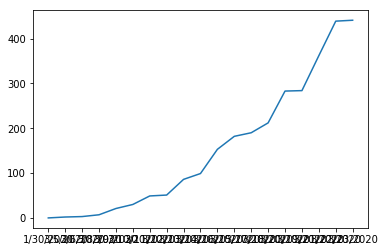

In [68]:
get_case_plot(df)

### Monitoring Large Networks

<b>Growth of confirmed cases within networks</b>
<br><i>Contact tracing and quarantine recommendations to large networks are important.</i>

<u>Case growth within Network 9:</u> <i>Case growth in Network 9 is seen to be flattening, with the latest case recorded 3/18/20.
This could indicate that the quarantine and preventive measures imposed on this network has been effective. Although we need to wait for more details and contact tracing of new cases to confirm. </i>

First Confirmed Case:  2020-03-09
Latest Confirmed Case:  2020-03-18


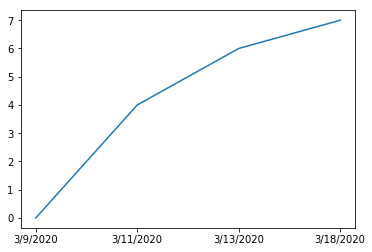

In [70]:
get_case_plot(df[df['case_no_int'].isin(comp_list[9])])

<u>Case growth within Network 6</u>

First Confirmed Case:  2020-03-08
Latest Confirmed Case:  2020-03-10


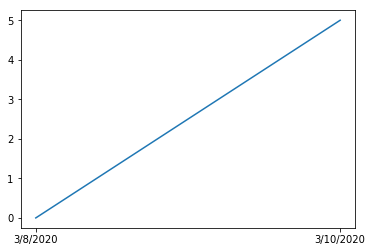

In [71]:
get_case_plot(df[df['case_no_int'].isin(comp_list[6])])

<u>Case growth among contacts of PH43:</u><i> No new cases among contacts of PH43 since 3/13/20</i>

First Confirmed Case:  2020-03-09
Latest Confirmed Case:  2020-03-13


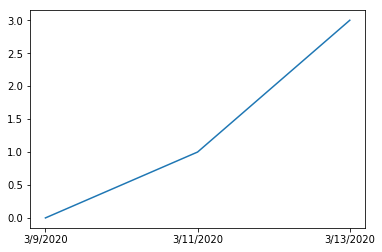

In [72]:
get_case_plot(df[df['case_no_int'].isin(contact_map[43])])